In [1]:
from abc import ABC, abstractmethod
import glob
import numpy as np
import pandas as pd
from scipy import stats
import torch
from torch import nn
from torch import utils
from torch import optim

from senseis.torch_module.loss import WeightedMSELoss
from senseis.torch_module.loss import CorrelationLoss

from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_built()
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
cpu = torch.device('cpu')

In [4]:
default_batch_size = 256
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True, 'num_workers' : 0}
score_args = {'batch_size' : default_batch_size, 'shuffle' : False, 'num_workers' : 0}
if use_cuda:
    loader_args.update({'pin_memory' : True})
    score_args.update({'pin_memory' : True})

In [5]:
class SLReporter(ABC):
    @abstractmethod
    def train_gather(self, epoch, batch_idx, batch_size, dataset_size, loss):
        pass
    @abstractmethod
    def eval_gather(self, train_epoch, loss, accuracy):
        pass
    @abstractmethod
    def eval_pred_gather(self, train_epoch, predictions, targets):
        pass
    @abstractmethod
    def train_reset(self):
        pass
    @abstractmethod
    def eval_reset(self):
        pass

class SLEpochLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

class SLBatchLossReporter(SLReporter):
    def __init__(self, batch_size, frequency, report_frequency = 0, eval_report_frequency = 0):
        self.batch_size = batch_size
        self.frequency = frequency
        self.report_frequency = report_frequency
        self.eval_report_frequency = eval_report_frequency
        self.losses = []
        self.eval_losses = []
        self.eval_predictions_targets = []
    def train_gather(self, epoch, batch_idx, dataset_size, loss):
        if epoch % self.frequency == 0 and (batch_idx + 1) * self.batch_size >= dataset_size:
            self.losses.append((epoch, loss))
        if self.report_frequency > 0 and epoch % self.report_frequency == 0:
            print("Epoch {}, {}/{}: {}".format(epoch, batch_idx * self.batch_size, dataset_size, loss))
    def eval_gather(self, train_epoch, loss, accuracy):
        self.eval_losses.append((train_epoch, loss, accuracy))
        if self.eval_report_frequency > 0 and train_epoch % self.eval_report_frequency == 0:
            print("Epoch {}: loss {} accuracy {}".format(train_epoch, loss, accuracy))
    def eval_pred_gather(self, train_epoch, predictions, targets):
        self.eval_predictions_targets.append((train_epoch, predictions, targets))
    def train_reset(self):
        self.losses = []
    def eval_reset(self):
        self.eval_losses = []
        self.eval_predictions_targets = []

In [6]:
data_dir = '../data/'

In [7]:
files = glob.glob(data_dir + 'etl_s2_v2*.parquet')
files

['../data/etl_s2_v2_1680419520_1680590400.parquet',
 '../data/etl_s2_v2_1680112320_1680265920.parquet',
 '../data/etl_s2_v2_1679805120_1679958720.parquet',
 '../data/etl_s2_v2_1679958720_1680112320.parquet',
 '../data/etl_s2_v2_1680590400_1680744000.parquet',
 '../data/etl_s2_v2_1679178240_1679331840.parquet',
 '../data/etl_s2_v2_1680265920_1680419520.parquet',
 '../data/etl_s2_v2_1679485440_1679651520.parquet',
 '../data/etl_s2_v2_1679651520_1679805120.parquet',
 '../data/etl_s2_v2_1679331840_1679485440.parquet']

In [8]:
ticker = 'ETH-USD'

In [9]:
data = pd.read_parquet(files[0])
columns = data.columns

In [10]:
ticker_columns = []
for col in columns:
    if col.startswith(ticker):
        ticker_columns.append(col)

In [11]:
ticker_columns += ['book_mean_return_27', 'sequence_interval_s']

In [12]:
len(ticker_columns)

710

In [13]:
data = pd.DataFrame(columns=ticker_columns)
for file in files:
    df = pd.read_parquet(file, columns=ticker_columns)
    data = pd.concat([data, df])

In [14]:
data.sort_index(inplace=True)

In [15]:
data.shape

(1530331, 710)

In [16]:
target_columns = [
    (f'{ticker}:book_volatility_9',   9,   f'{ticker}:book_volatility_9_target',   f'{ticker}:book_volatility_9_weight'),
    (f'{ticker}:book_volatility_27',  27,  f'{ticker}:book_volatility_27_target',  f'{ticker}:book_volatility_27_weight'),
    (f'{ticker}:book_volatility_81',  81,  f'{ticker}:book_volatility_81_target',  f'{ticker}:book_volatility_81_weight'),
    (f'{ticker}:book_volatility_162', 162, f'{ticker}:book_volatility_162_target', f'{ticker}:book_volatility_162_weight'),
    (f'{ticker}:book_volatility_324', 324, f'{ticker}:book_volatility_324_target', f'{ticker}:book_volatility_324_weight'),
    (f'{ticker}:book_volatility_648', 648, f'{ticker}:book_volatility_648_target', f'{ticker}:book_volatility_648_weight'),
    (f'{ticker}:book_volatility_960', 960, f'{ticker}:book_volatility_960_target', f'{ticker}:book_volatility_960_weight'),
]

In [17]:
target_column_names = [colname for (_, _, colname, _) in target_columns]
weight_column_names = [colname for (_, _, _, colname) in target_columns]

In [18]:
for (colname, offset, tcolname, wcolname) in target_columns:
    data[tcolname] = data[colname]
    data[tcolname] = data[tcolname].shift(-1 * offset)
    data[wcolname] = data[colname]
    data[wcolname] = data[wcolname].shift(-1 * offset)

In [19]:
data = data.drop([data.index[k] for k in range(-1, -961, -1)])

In [ ]:
data.shape

(1529371, 724)

In [ ]:
data.isna().sum().sum()

7082640

In [ ]:
data.fillna(method='ffill', inplace=True)

In [ ]:
for col in data.columns:
    max_val = np.nanmax(data[col][data[col] != np.inf])
    min_val = np.nanmin(data[col][data[col] != -np.inf])
    data[col].replace([np.inf, -np.inf], [max_val, min_val], inplace=True)

In [ ]:
data.isna().sum().sum()

0

In [ ]:
data.fillna(0., inplace=True)

In [ ]:
input_columns = [col for col in data.columns if col not in target_column_names and col not in weight_column_names]

In [ ]:
X = np.float32(data[input_columns].to_numpy())

In [ ]:
Y = np.float32(data[target_column_names].to_numpy())

In [ ]:
W = np.float32(data[target_column_names].to_numpy())

In [ ]:
def ts_train_test_split(X, Y, W, pct):
    n = X.shape[0]
    train_size = int(n * (1 - pct))
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    W_train = W[:train_size]
    X_test = X[train_size:]
    Y_test = Y[train_size:]
    W_test = W[train_size:]
    return (X_train, Y_train, W_train, X_test, Y_test, W_test)

In [ ]:
X_train, Y_train, W_train, X_test, Y_test, W_test = ts_train_test_split(X, Y, W, 0.2)

In [ ]:
# normalizing X, Y and W for NN

In [ ]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

In [ ]:
X_train_std[X_train_std == 0.] = 1.

In [ ]:
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

In [ ]:
Y_train_mean = Y_train.mean(axis=0)
Y_train_std = Y_train.std(axis=0)

In [ ]:
Y_train_norm = (Y_train - Y_train_mean) / Y_train_std
Y_test_norm = (Y_test - Y_train_mean) / Y_train_std

In [ ]:
W_train_mean = W_train.mean(axis=0)
W_train_std = W_train.std(axis=0)

In [ ]:
W_train_std[W_train_std == 0.] = 1.

In [ ]:
W_train_norm = np.abs((W_train - W_train_mean) / W_train_std)
W_test_norm = np.abs((W_test - W_train_mean) / W_train_std)

In [ ]:
class Dataset(utils.data.Dataset):
    def __init__(self, X, Y, W):
        self.X = X
        self.Y = Y
        self.W = W
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        w = self.W[idx]
        return (x, y, w)

    def __len__(self):
        return self.X.shape[0]

In [ ]:
# NN Model

In [ ]:
class NN_V1(nn.Module):
    def __init__(self, isz, osz, hsz):
        super(NN_V1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(isz, hsz),
            nn.SiLU(inplace=True),
            nn.Linear(hsz, osz),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [ ]:
def regression_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    for batch_idx, (data, target, _) in enumerate(loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = model(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        reporter.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [ ]:
def weighted_regression_train(model, device, loader, optimizer, loss, epoch, reporter):
    model.train()
    for batch_idx, (data, target, weight) in enumerate(loader):
        optimizer.zero_grad()
        data, target, weight = data.to(device), target.to(device), weight.to(device)
        output = model(data)
        l = loss(output, target, weight)
        l.backward()
        optimizer.step()
        reporter.train_gather(epoch, batch_idx, len(loader.dataset), l.item())

In [ ]:
def regression_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for (data, target, _) in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += loss(output, target).item()
            reporter.eval_pred_gather(train_epoch, output, target)
    total_loss /= len(loader.dataset)
    #NOTE: regression does not have accuracy
    reporter.eval_gather(train_epoch, total_loss, total_loss)

In [ ]:
def weighted_regression_validate(model, device, loader, loss, train_epoch, reporter):
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for (data, target, weight) in loader:
            data, target, weight = data.to(device), target.to(device), weight.to(device)
            output = model(data)
            total_loss += loss(output, target, weight).item()
            reporter.eval_pred_gather(train_epoch, output, target)
    total_loss /= len(loader.dataset)
    #NOTE: regression does not have accuracy
    reporter.eval_gather(train_epoch, total_loss, total_loss)

In [ ]:
def regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 1.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        regression_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        regression_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_losses[-1][1]
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [ ]:
def weighted_regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epoch, patience, patience_decay, reporter):
    validation_loss = 1.
    patience_count = patience
    patience = int(patience * patience_decay)
    reset_patience = False
    for epoch in range(total_epoch):
        weighted_regression_train(model, device, train_loader, optimizer, loss, epoch, reporter)
        weighted_regression_validate(model, device, eval_loader, loss, epoch, reporter)
        new_validation_loss = reporter.eval_losses[-1][1]
        scheduler.step(new_validation_loss)
        if new_validation_loss < validation_loss:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count = patience
            if reset_patience:
                patience = int(patience * patience_decay)
                reset_patience = False
        else:
            print("Validation Loss: {}".format(new_validation_loss))
            validation_loss = new_validation_loss
            patience_count -= 1
            reset_patience = True
            if patience_count <= 0:
                print("Improvement stopped at epoch {}, validation loss {}".format(epoch, new_validation_loss))
                break

In [ ]:
# training

In [ ]:
trainset, evalset = Dataset(X_train_norm, Y_train_norm, W_train_norm), Dataset(X_test_norm, Y_test_norm, W_test_norm)

In [ ]:
train_loader = utils.data.DataLoader(trainset, **loader_args)
eval_loader = utils.data.DataLoader(evalset, **loader_args)
score_loader = utils.data.DataLoader(evalset, **score_args)

In [ ]:
model = NN_V1(len(input_columns), len(target_column_names), 2048)
model = model.to(device)

In [ ]:
learning_rate = 0.00001
total_epochs = 30
patience = 14
patience_decay = 0.8
optimizer = optim.Adam(model.parameters(recurse=True), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience / 4, threshold=0.000001)
#loss = nn.MSELoss()
#loss = WeightedMSELoss()
loss = CorrelationLoss()
reporter = SLEpochLossReporter(default_batch_size, 1, 1)

In [ ]:
regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

TypeError: var() received an invalid combination of arguments - got (Tensor, unbaised=bool, keepdim=bool, dim=int), but expected one of:
 * (Tensor input, tuple of ints dim, *, int correction, bool keepdim, Tensor out)
 * (Tensor input, tuple of ints dim, bool unbiased, bool keepdim, *, Tensor out)
 * (Tensor input, bool unbiased)
 * (Tensor input, tuple of names dim, *, int correction, bool keepdim, Tensor out)
 * (Tensor input, tuple of names dim, bool unbiased, bool keepdim, *, Tensor out)


In [55]:
weighted_regression_train_validate(model, device, train_loader, eval_loader, optimizer, scheduler, loss, total_epochs, patience, patience_decay, reporter)

Epoch 0, 1223424/1223496: 1.1323518753051758
Validation Loss: 0.006631351726611488
Epoch 1, 1223424/1223496: 0.5220959782600403
Validation Loss: 0.0072013062339536405
Epoch 2, 1223424/1223496: 0.49629560112953186
Validation Loss: 0.008161664918144235
Epoch 3, 1223424/1223496: 0.5582373738288879
Validation Loss: 0.008772676056923065
Epoch 4, 1223424/1223496: 1.3284813165664673
Validation Loss: 0.00906933026163735
Epoch 5, 1223424/1223496: 0.517887532711029
Validation Loss: 0.009238445427742208
Epoch 6, 1223424/1223496: 0.9655164480209351
Validation Loss: 0.009263997154913974
Epoch 7, 1223424/1223496: 0.49919429421424866
Validation Loss: 0.009271026348648726
Epoch 8, 1223424/1223496: 0.2901475131511688
Validation Loss: 0.009297075091160508
Epoch 9, 1223424/1223496: 0.3212118446826935
Validation Loss: 0.009315994618715536
Epoch 10, 1223424/1223496: 0.5538848638534546
Validation Loss: 0.009308314787401293
Epoch 11, 1223424/1223496: 0.570792555809021
Validation Loss: 0.009317314958007276
Ep

In [56]:
X_valid = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Y_predict_norm = model(X_valid).to(cpu).detach().numpy()
Y_predict = (Y_predict_norm * Y_train_std) + Y_train_mean

In [57]:
r2_score(Y_test, Y_predict)

-0.3310203301415609

In [58]:
r, p = pearsonr(Y_test[:,0], Y_predict[:,0])
r

0.6527753656646209

In [59]:
r, p = pearsonr(Y_test[:,1], Y_predict[:,1])
r

0.6884866721797804

In [60]:
r, p = pearsonr(Y_test[:,3], Y_predict[:,3])
r

0.569374336327632

In [61]:
r, p = pearsonr(Y_test[:,6], Y_predict[:,6])
r

0.24372705484447504

In [62]:
# plotting it out

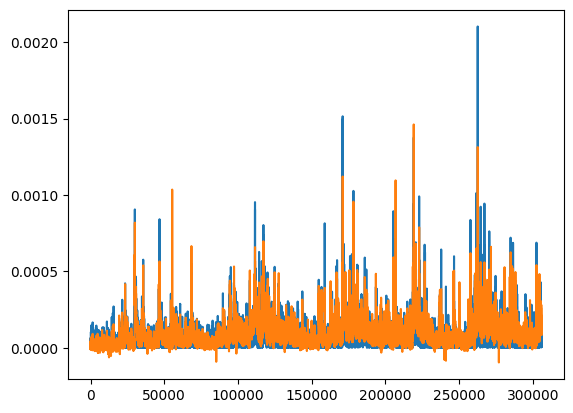

In [63]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.plot(Y_predict[:,0])

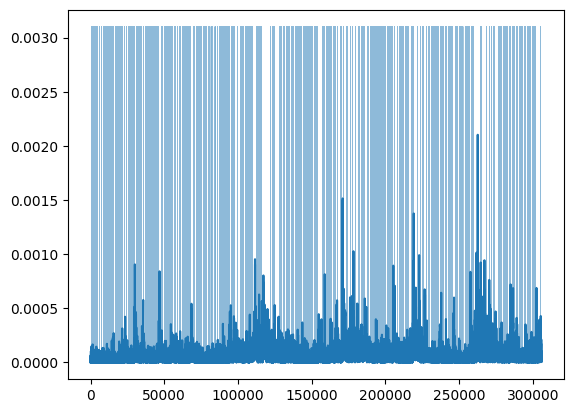

In [64]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,0])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,0]), max(Y_test[:,0]) + 0.001, where=np.abs(Y_test[:,0] - Y_predict[:,0]) < 0.00005, alpha=0.5)

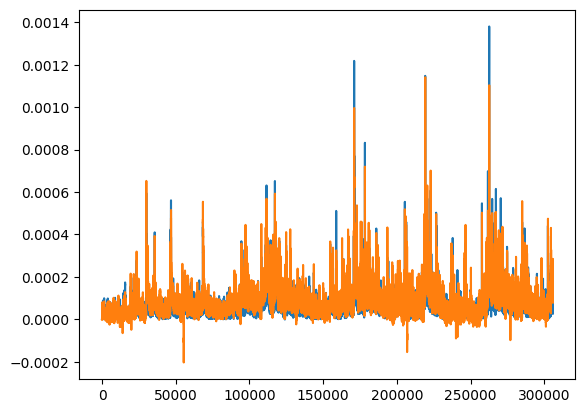

In [65]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.plot(Y_predict[:,1])

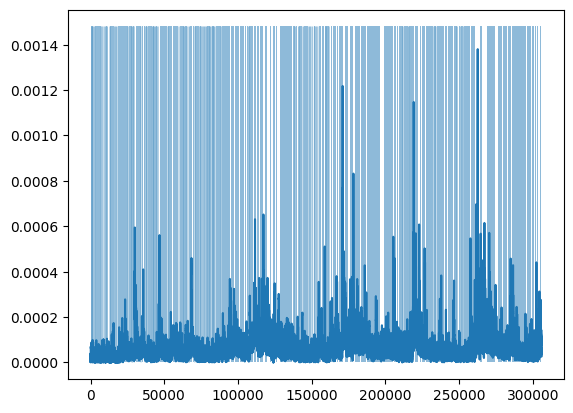

In [66]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,1])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,1]), max(Y_test[:,1]) + 0.0001, where=np.abs(Y_test[:,1] - Y_predict[:,1]) < 0.00005, alpha=0.5)

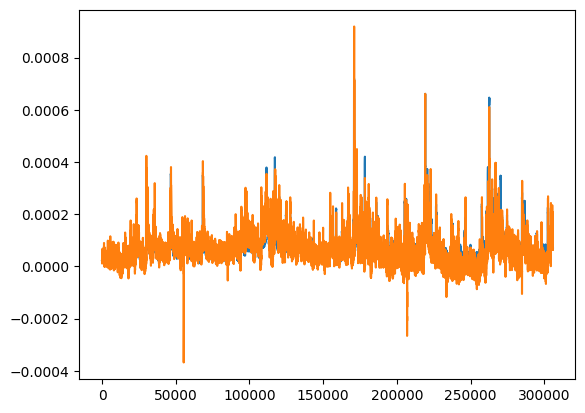

In [67]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.plot(Y_predict[:,3])

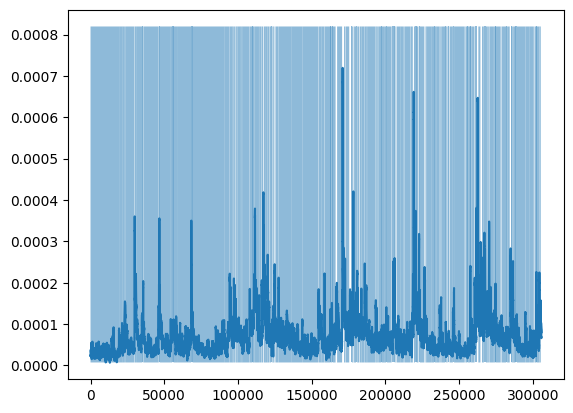

In [68]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,3])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,3]), max(Y_test[:,3]) + 0.0001, where=np.abs(Y_test[:,3] - Y_predict[:,3]) < 0.0001, alpha=0.5)

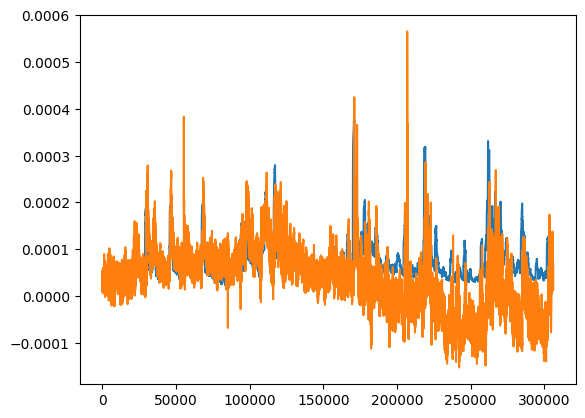

In [69]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.plot(Y_predict[:,6])

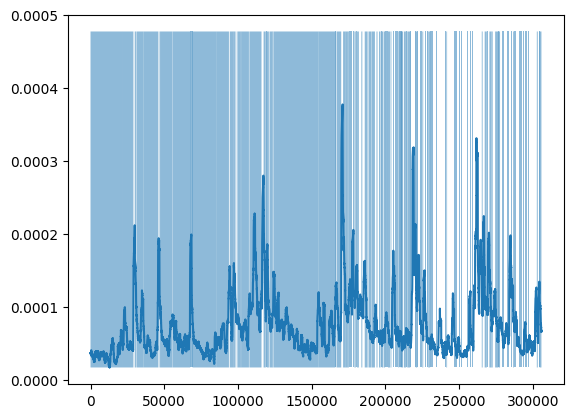

In [70]:
fig, ax = plt.subplots()
ax.plot(Y_test[:,6])
ax.fill_between(range(Y_test.shape[0]), min(Y_test[:,6]), max(Y_test[:,6]) + 0.0001, where=np.abs(Y_test[:,6] - Y_predict[:,6]) < 0.0001, alpha=0.5)